In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="3"


## Hyperparam

In [13]:
params = dict(
    batch_size = 256,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 3e-3
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation

In [14]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
labeled =10
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:100])
plt.show()

In [ ]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, reuse=False, sigmoid=True):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    if sigmoid:
        return tf.nn.sigmoid(x)
    else:
        return x
    
def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d)

In [6]:
l=tf.layers
def lrelu(x):
    return tf.nn.leaky_relu(x,alpha=0.1)

def discriminator(x,training_pl):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        h= tf.reshape(x,[-1,28,28,1])
        h = l.conv2d(h,64,5,2,padding='SAME',activation=lrelu)
        h = l.conv2d(h,128,5,2,padding='SAME',activation=lrelu)
        h = l.dropout(h,training_pl)
        h = l.conv2d(h,256,5,2,padding='SAME',activation=lrelu)
        h = l.dropout(h,training_pl)
        h = l.conv2d(h,512,5,1,padding='SAME',activation=lrelu)
        h = l.dropout(h,training_pl)
        h = l.flatten(h)
        h = l.dense(h,1,activation=tf.sigmoid)
    return h

def generator(z,training_pl):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        h = lrelu(l.batch_normalization(l.dense(z,256*7*7),training=training_pl,momentum=0.9))
        h = tf.reshape(h,[-1,7,7,256])
        h = l.dropout(h,training_pl)
        h = l.conv2d_transpose(h,128,[5,5],[2,2], padding='SAME')
        h = lrelu(l.batch_normalization(h,training=training_pl))
        h = l.conv2d_transpose(h,64,[5,5],[2,2], padding='SAME')
        h = lrelu(l.batch_normalization(h,training=training_pl))
        h = l.conv2d(h,1,5,padding='SAME',activation=tf.sigmoid)
    return h



In [24]:
h1_size = 150
h2_size = 350
Z_DIM = 100
IM_HEIGHT = 28
IM_WIDTH = 28
IM_SIZE = IM_HEIGHT * IM_WIDTH

def generator(batch_size):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        z_seed = tf.truncated_normal([batch_size, Z_DIM], mean=0, stddev=1, name='z_seed')
        with tf.name_scope('layer_1'):
            w1 = tf.get_variable('g_w1', [Z_DIM, h1_size], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b1 = tf.get_variable('g_b1', [h1_size], dtype=tf.float32, initializer=tf.zeros_initializer())
            h1 = tf.nn.relu(tf.matmul(z_seed, w1) + b1)
        with tf.name_scope('layer_2'):
            w2 = tf.get_variable('g_w2', [h1_size, h2_size], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b2 = tf.get_variable('g_b2', [h2_size], dtype=tf.float32, initializer=tf.zeros_initializer())
            h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)

        with tf.name_scope('layer_3'):
            w3 = tf.get_variable('g_w3', [h2_size, IM_SIZE], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b3 = tf.get_variable('g_b3', [IM_SIZE], dtype=tf.float32, initializer=tf.zeros_initializer())
            g_output = tf.nn.tanh(tf.matmul(h2, w3) + b3)
    return g_output


def discriminator(x_input, keep_prob=0.4):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.name_scope('layer_d_1'):
            w1 = tf.get_variable('d_w1', [IM_SIZE, h2_size], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b1 = tf.get_variable('d_b1', [h2_size], dtype=tf.float32, initializer=tf.zeros_initializer())
            h1 = tf.nn.relu(tf.matmul(x_input, w1) + b1)
            h1 = tf.nn.dropout(h1, keep_prob=keep_prob)

        with tf.name_scope('layer_d_2'):
            w2 = tf.get_variable('d_w2', [h2_size, h1_size], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b2 = tf.get_variable('d_b2', [h1_size], dtype=tf.float32, initializer=tf.zeros_initializer())
            h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
            h2 = tf.nn.dropout(h2, keep_prob=keep_prob)

        with tf.name_scope('layer_d_3'):
            w3 = tf.get_variable('d_w3', [h1_size, 1], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
            b3 = tf.get_variable('d_b3', [1], dtype=tf.float32, initializer=tf.zeros_initializer())
            d_output = tf.matmul(h2, w3) + b3
        return d_output

## Build model

In [25]:
tf.reset_default_graph()

In [26]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [27]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net

# samples = generator(noise,is_training_pl)
# real_score = discriminator(data,is_training_pl)
# fake_score = discriminator(samples,is_training_pl)

samples = generator(params['batch_size'])
real_score = discriminator(data)
fake_score = discriminator(samples)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# optimizer = tf.train.RMSPropOptimizer(params['lr'])
optimizer = tf.train.AdamOptimizer(params['lr'])

d_grads = tf.gradients(loss, disc_vars)
g_grads = tf.gradients(-loss, gen_vars)

variables = disc_vars + gen_vars
grads = d_grads + g_grads

apply_vec = [(g, v)for (g, v) in zip(grads, variables)]
global_step = tf.Variable(0, name='global_step',trainable=False)
train_op = optimizer.apply_gradients(apply_vec, global_step=global_step)      

In [28]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

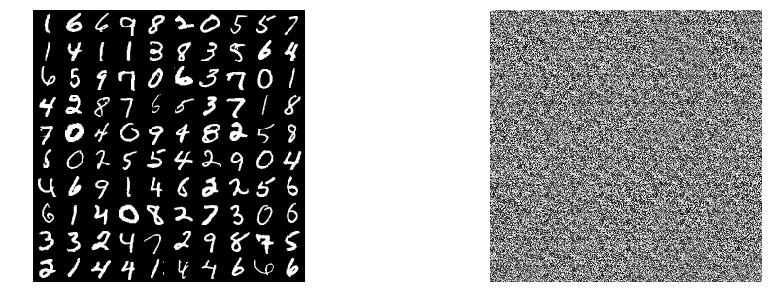

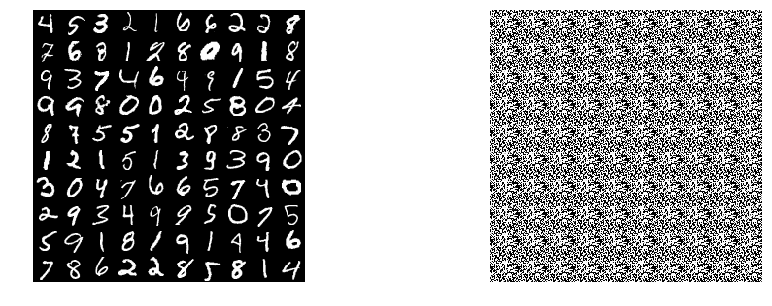

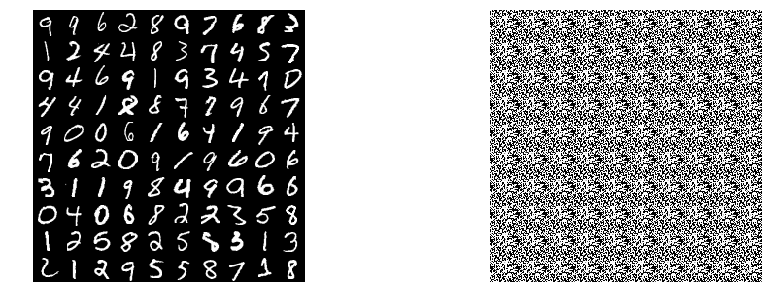

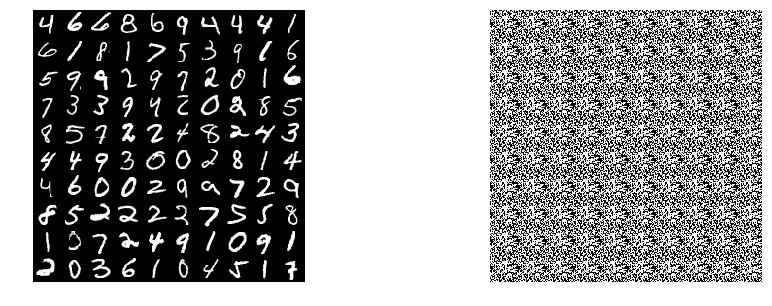

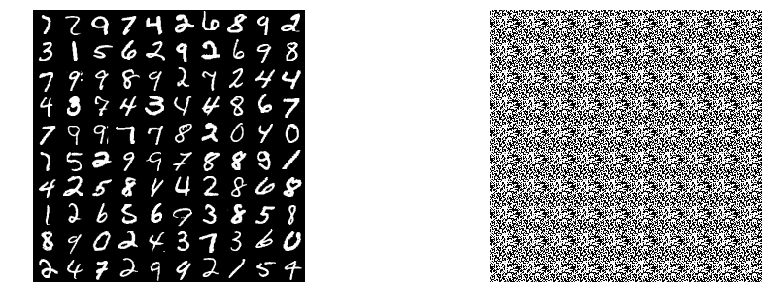

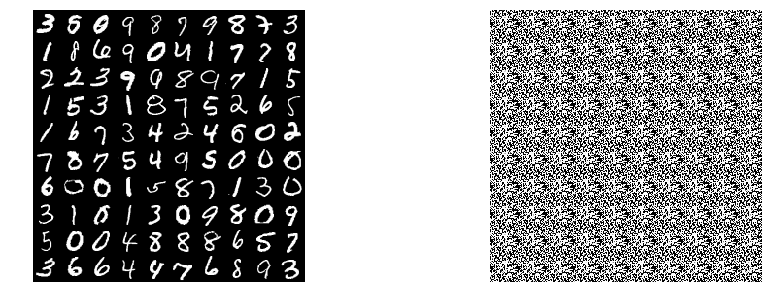

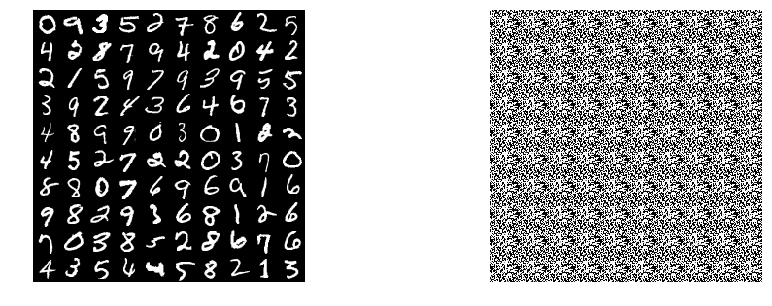

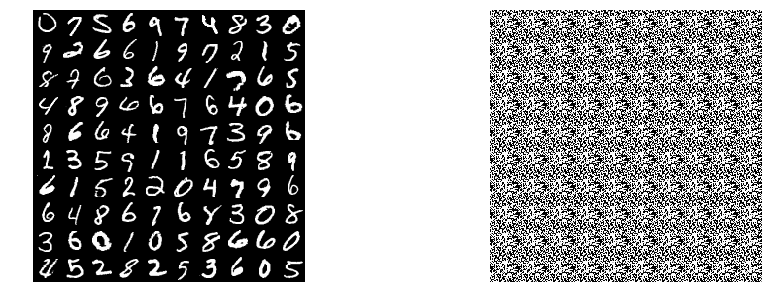

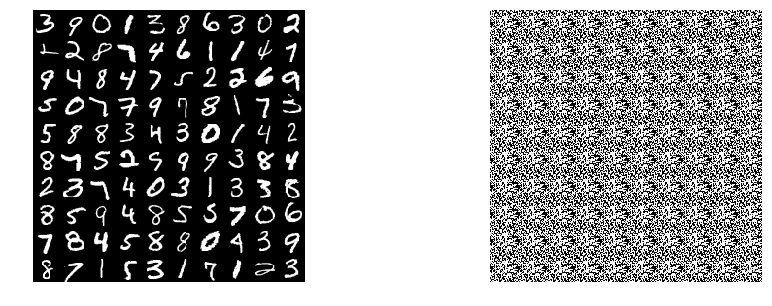

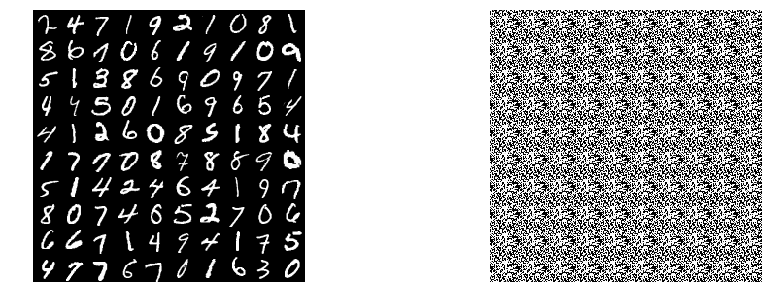

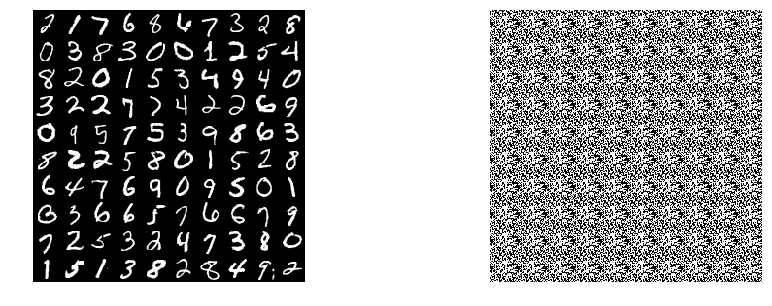

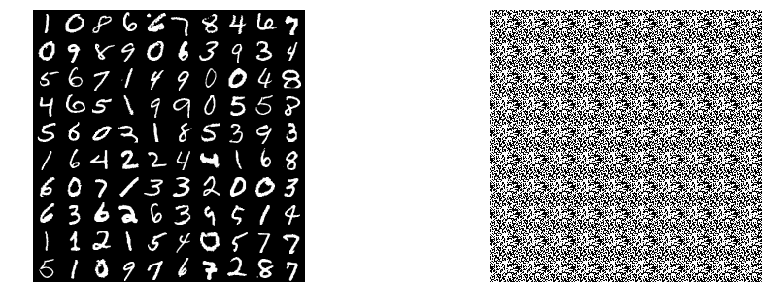

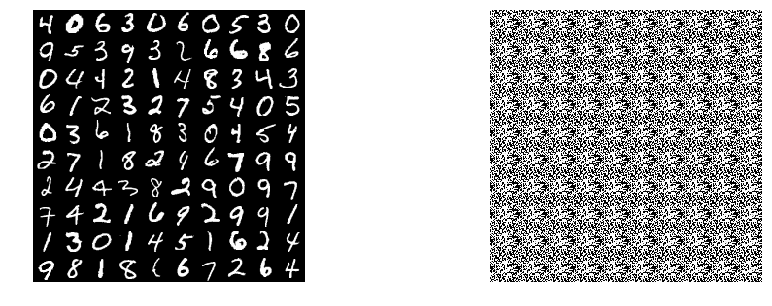

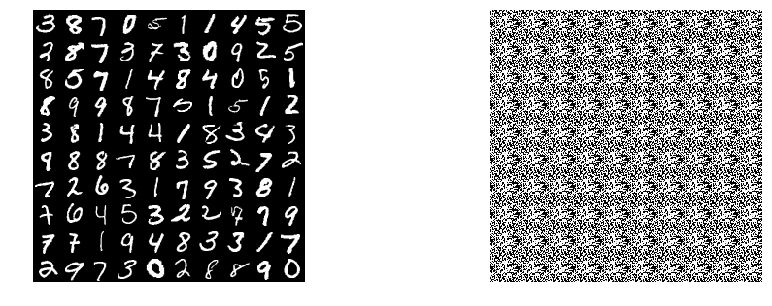

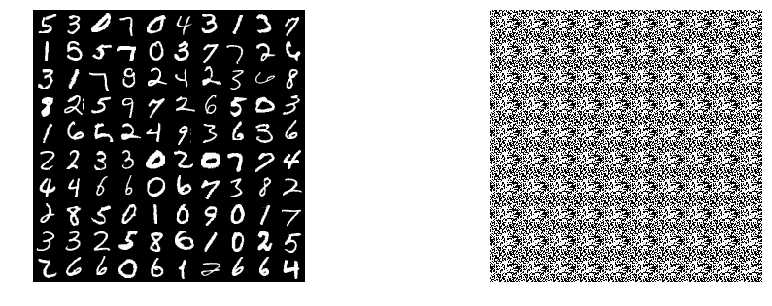

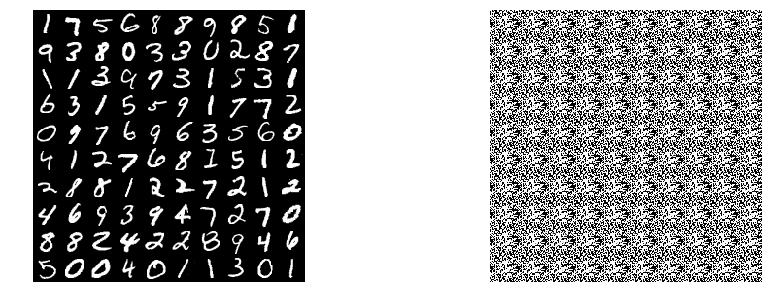

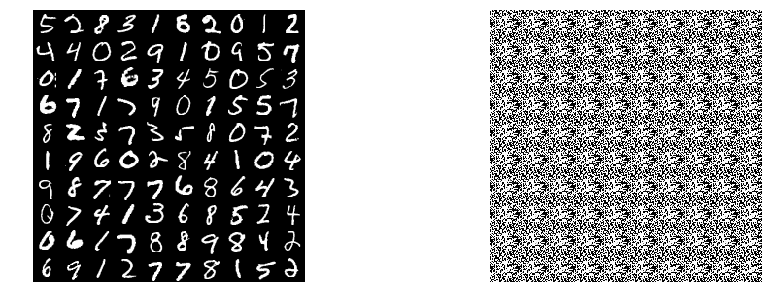

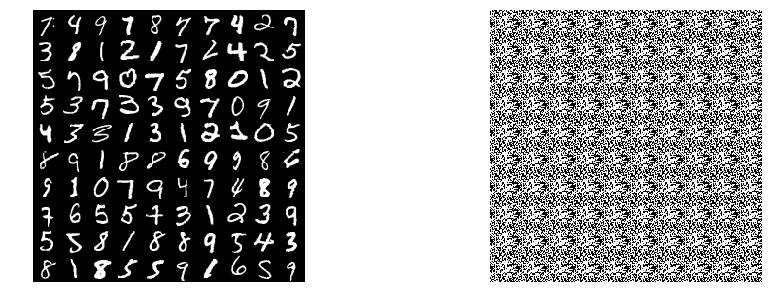

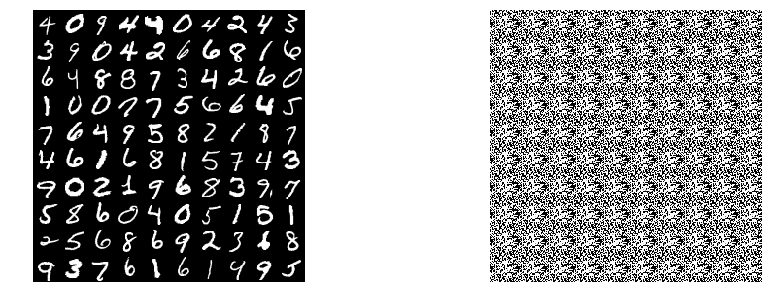

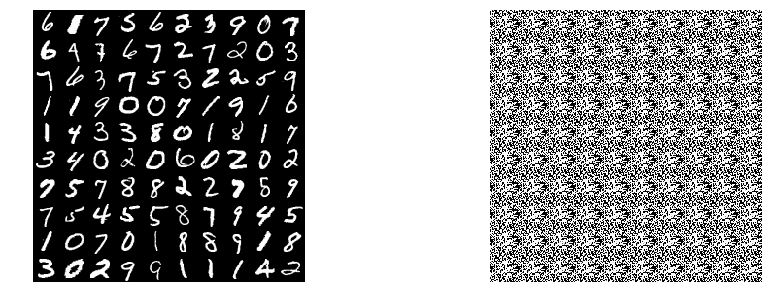

In [29]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 1000

for i in tqdm(range(20000)):
    f, _= sess.run([[loss], train_op],{is_training_pl:True})
    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:False})
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()

In [ ]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
noise_pert = noise + 5 * perturb

# samples = generator(noise,is_training_pl)
samples_perturb = generator(noise_pert, is_training_pl,output_dim=params['x_dim'], reuse=True)

samp_adv = samples + 1 * tf.nn.l2_normalize(samples-samples_perturb,dim=[1])


In [ ]:
xx,yy = sess.run([samples,samples_perturb],{is_training_pl:False})

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
show_digits(xx)
plt.subplot(122)
show_digits(yy)
plt.show()